# MOIRAI - What is it?
### Characteristics
- MOIRAI is a transformer-based model designed for time series forecasting.
- Zero-shot forecasting capabilities, meaning it can forecast without needing to be trained on specific datasets.
- Probabilistic forecasting
- Flexible Data Distribution
- Flexible Frequencies
### Main Idea
- MOIRAI is based on the idea of large language models (LLMs) and applies this concept to time series forecasting.
- Therefore it needs a large amount of data to be effective. That is why the authors introduced the LOTSA Database
- They employ a masked-encoder Transformer: future patches are replaced by learnable [MASK] tokens, and multi-head self-attention over the past plus these masks lets the model infer a full probability distribution for the unseen time-series values.

### Technical Details
- Predicts future values by processing the past window with a Transformer.
- During training, it learns to turn past samples into a probability distribution for future points.
- Learns how much weight to assign to each of four fixed distribution families.
- Combines those weighted distributions into one mixture; point forecasts come from its mean or median.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB


/var/folders/7f/pn2lysgd6cx02fkc066bbrp40000gn/T/ipykernel_21569/1263838836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil_df['ds'] = pd.to_datetime(wti_oil_df['ds'])


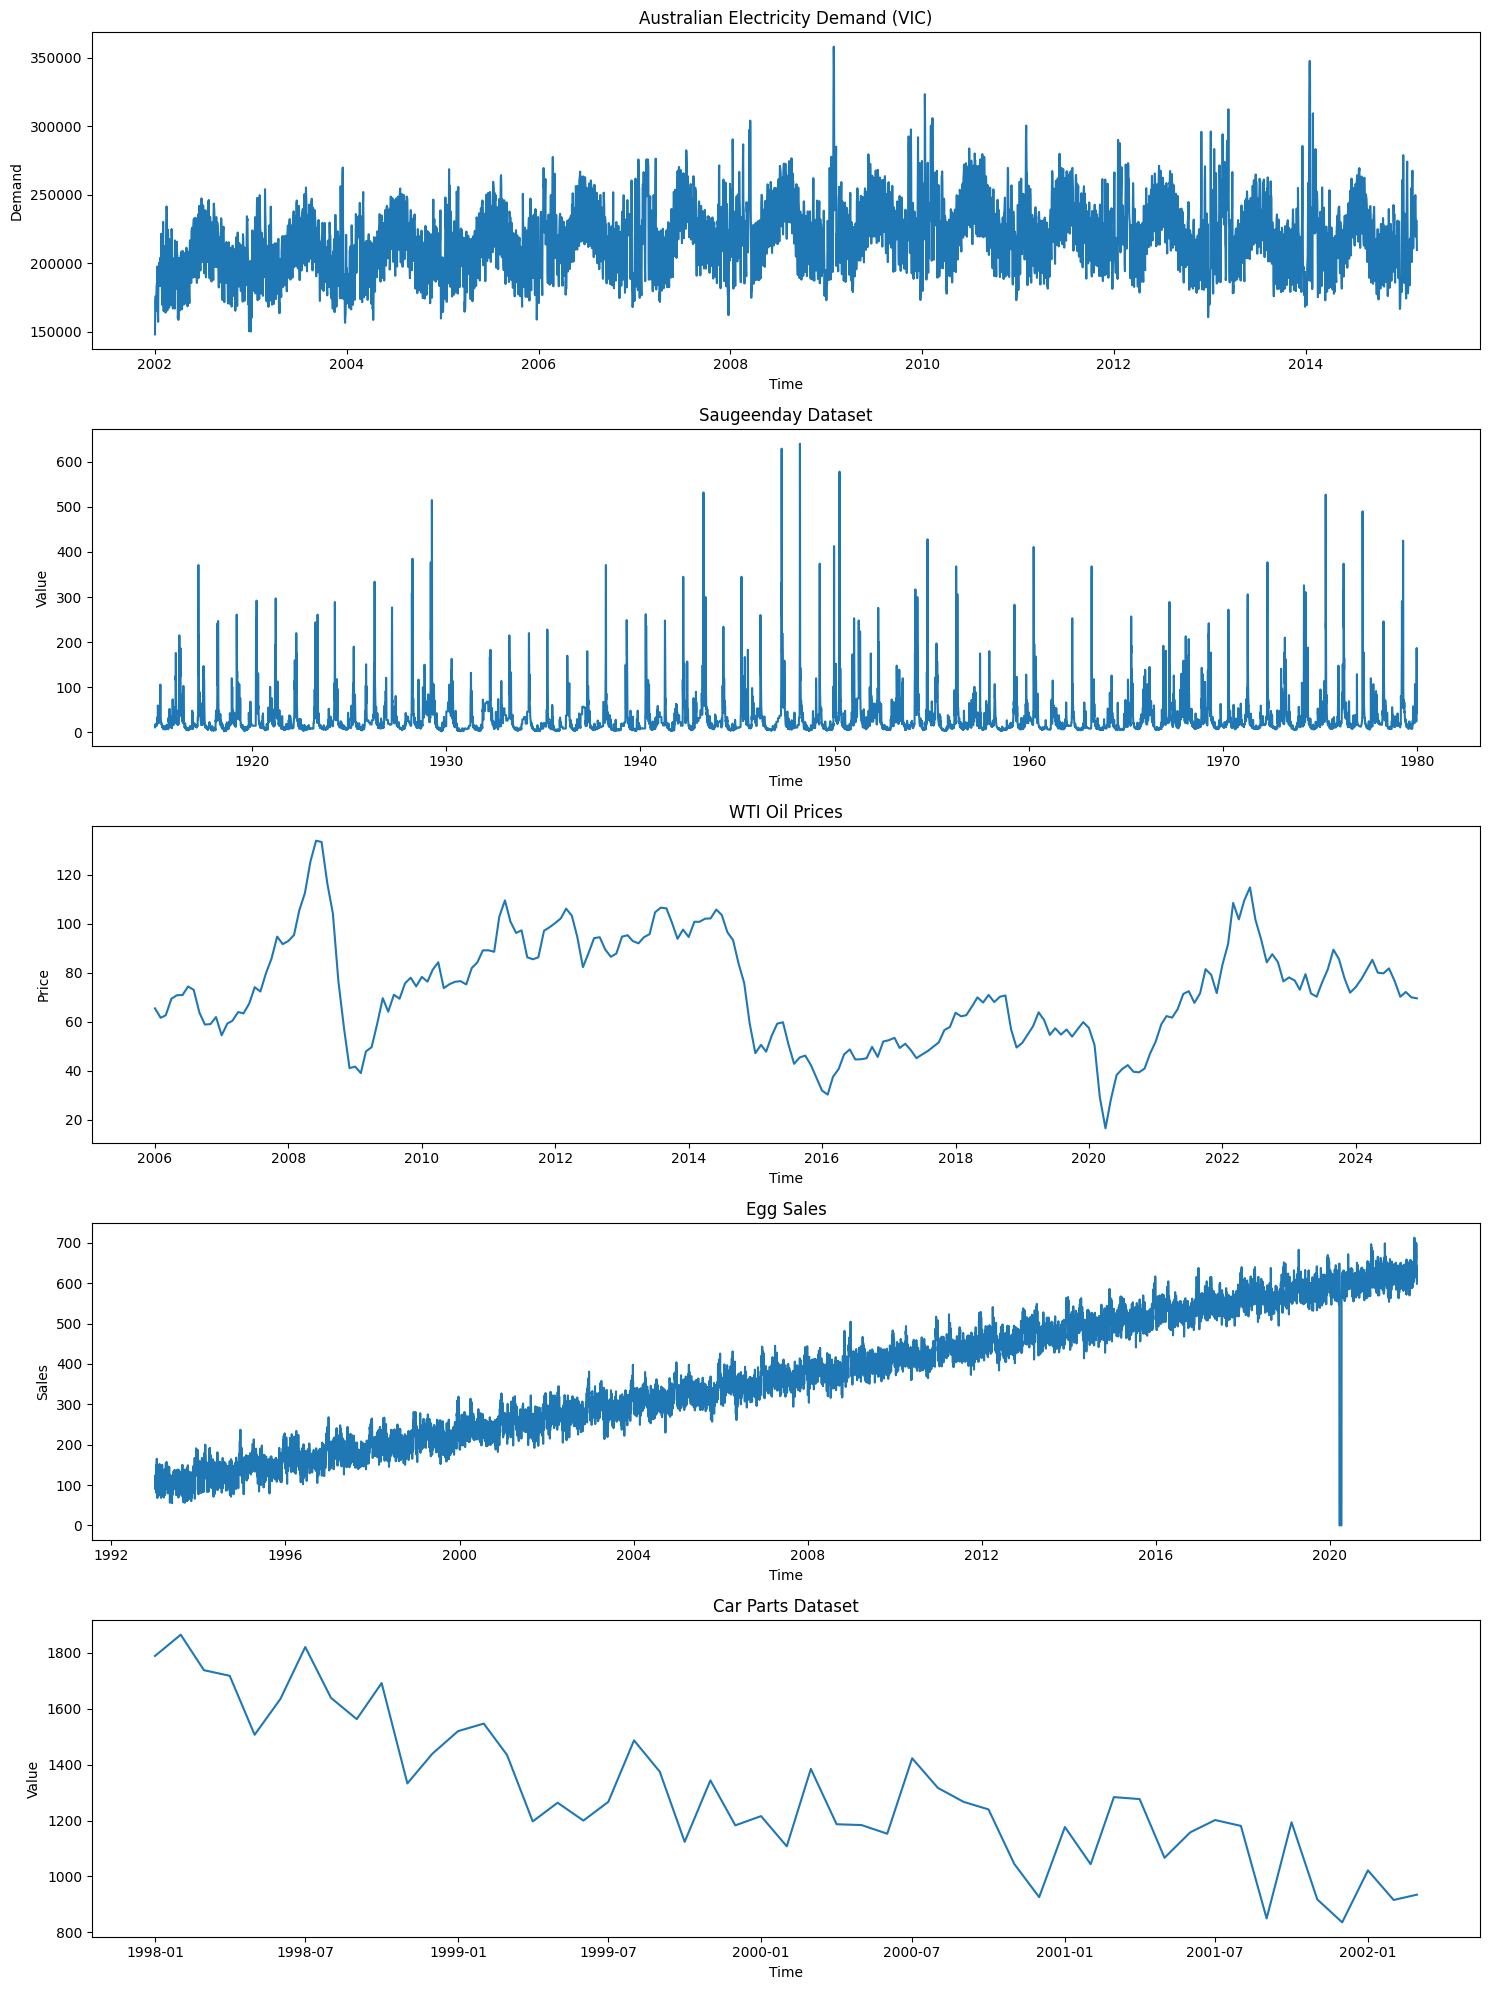

In [34]:
%run "datagetter.ipynb"
%run "basic_functions.ipynb"

In [35]:
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def moirai_forecast(train_df, test_df, dataset_name='unkown', alpha=0.05, figsize=(14, 6), show_plots=False):
    """
    Fit MOIRAI model and generate forecasts
    
    Parameters:
    -----------
    train_df : DataFrame with 'ds' and 'y' columns
    test_df : DataFrame with 'ds' and 'y' columns
    alpha : float, confidence interval width (default: 0.05 for 95% CI)
    figsize : tuple, figure size for plots (default: (14, 6))
    """
    # Calculate appropriate context length based on data
    # Use 25% of training data length, capped between 128 and 1024
    target_len = int(len(train_df) * 0.5)
    context_len = max(128, min(target_len, 1024))
    if show_plots:
        print(f"Using context_len={context_len} based on training data length of {len(train_df)}")
    
    # Load pre-trained MOIRAI module
    module = MoiraiModule.from_pretrained("Salesforce/moirai-1.1-R-base")
    
    # Create MOIRAI forecast model
    model = MoiraiForecast(
        module=module,
        prediction_length=len(test_df),  # Forecast horizon should match test set length
        context_length=context_len,      # Dynamically set based on dataset size
        patch_size="auto",               # Automatic patch size selection ? what is it
        num_samples=100,                 # Number of samples for probabilistic forecasting (Monte Carlo sampling) Explain
        target_dim=1,                    # Single time series dimension
        feat_dynamic_real_dim=0,         # No dynamic real features: explain these two
        past_feat_dynamic_real_dim=0,    # No past dynamic real features
    )
    
    # Create predictor and fit on training data
    predictor = model.create_predictor(batch_size=32)
    
    # Infer frequency from the training data
    freq = pd.infer_freq(train_df['ds'])
    if freq is None:
        # If frequency can't be inferred, try to calculate it manually
        time_diff = train_df['ds'].iloc[1] - train_df['ds'].iloc[0]
        if time_diff.days >= 1:
            freq = 'D'  # Daily
        else:
            freq = 'H'  # Hourly or finer


    
    try:
        # Create a Period object with proper frequency - this is the key fix!
        start_period = pd.Period(train_df['ds'].iloc[0], freq=freq)
        print(f"Created Period object: {start_period} with frequency: {start_period.freq}")
    except Exception as e:
        print(f"Could not create Period with freq {freq}: {e}")
        try:
            if 'M' in freq or 'month' in freq.lower():
                start_period = pd.Period(train_df['ds'].iloc[0], freq='M')
            elif 'D' in freq or 'day' in freq.lower():
                start_period = pd.Period(train_df['ds'].iloc[0], freq='D')
            else:
                start_period = pd.Period(train_df['ds'].iloc[0], freq='D')  # Default to daily
            print(f"Using fallback Period: {start_period} with frequency: {start_period.freq}")
        except Exception as e2:
            print(f"Period creation failed completely: {e2}")
            # Final fallback - this should not happen
            start_period = train_df['ds'].iloc[0]
    
    train_data = [{
        'start': start_period,  # Using Period object instead of Timestamp
        'target': train_df['y'].values.astype(float),
        'feat_dynamic_real': None
    }]
    
    # Generate forecasts
    forecasts = list(predictor.predict(train_data))
    forecast_samples = forecasts[0].samples
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'ds': test_df['ds'].values,
        'moirai': np.mean(forecast_samples, axis=0),  # Mean forecast
        'lower': np.quantile(forecast_samples, alpha/2, axis=0),      # Lower CI
        'upper': np.quantile(forecast_samples, 1-alpha/2, axis=0)     # Upper CI
    })
    
    if show_plots:
        # Plot the results
        plt.figure(figsize=figsize)
        
        # Plot training data
        plt.plot(train_df['ds'], train_df['y'], label='Training Data', color='blue')
        
        # Plot test data
        plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='green')
        
        # Plot forecast
        plt.plot(forecast_df['ds'], forecast_df['moirai'], label='Forecast', color='red')
        
        # Plot confidence intervals
        plt.fill_between(forecast_df['ds'],
                        forecast_df['lower'], 
                        forecast_df['upper'], 
                        color='red', 
                        alpha=0.2,
                        label=f'{int((1-alpha)*100)}% CI')
        
        # Add train/test split line
        split_date = test_df['ds'].iloc[0]
        plt.axvline(split_date, color='tab:red', linestyle='--', label='Train/Test Split')
        
        plt.title(f'MOIRAI Forecast on {dataset_name}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return forecast_df['moirai'].values



Using context_len=128 based on training data length of 205
Could not create Period with freq MS: Invalid frequency: <MonthBegin>
Using fallback Period: 2006-01 with frequency: <MonthEnd>


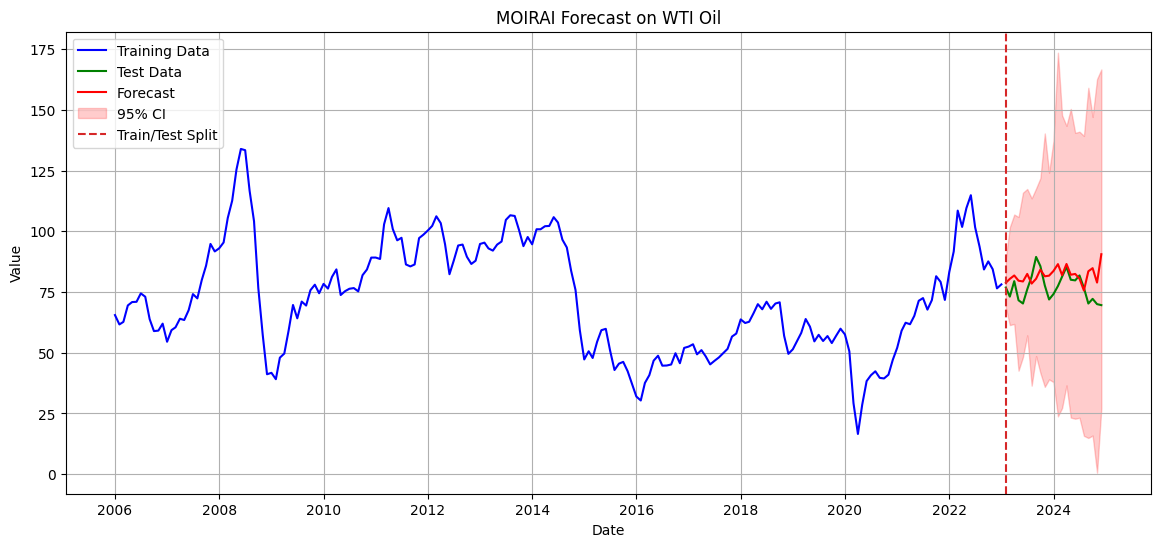

In [36]:
train_df, test_df = split_train_test(wti_oil_df, test_size=0.1)
moirai_forecasts = moirai_forecast(
    train_df=train_df,
    test_df=test_df,
    dataset_name="WTI Oil",
    show_plots=True,
)


Using context_len=1024 based on training data length of 21366
Created Period object: 1915-01-01 with frequency: <Day>


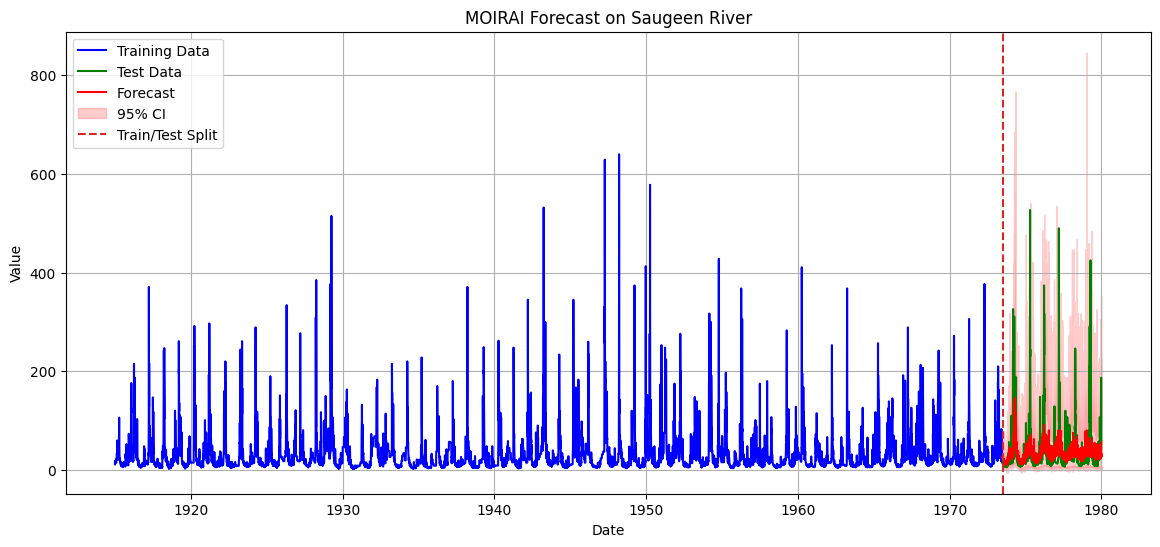

In [37]:

train_df, test_df = split_train_test(saugeen_river_df, test_size=0.1)
moirai_forecasts = moirai_forecast(
    train_df=train_df,
    test_df=test_df,
    dataset_name="Saugeen River",
    show_plots=True,
)


In [ ]:
train_df, test_df = split_train_test(egg_sales_df, test_size=0.1)
moirai_forecasts = moirai_forecast(
    train_df=train_df,
    test_df=test_df,
    dataset_name="Egg Sales",
    show_plots=True,
)


Using context_len=1024 based on training data length of 9532
Created Period object: 1993-01-01 with frequency: <Day>


Using context_len=1024 based on training data length of 4326
Created Period object: 2002-01-01 with frequency: <Day>


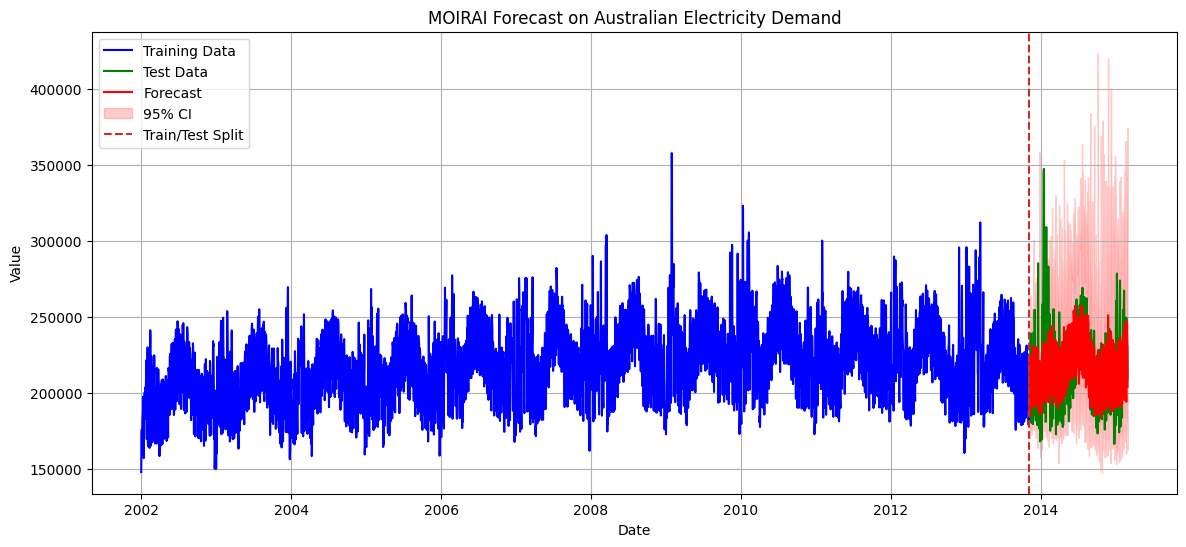

In [ ]:

train_df, test_df = split_train_test(australian_electricity_demand_df, test_size=0.1)
moirai_forecasts = moirai_forecast(
    train_df=train_df,
    test_df=test_df,
    dataset_name="Australian Electricity Demand",
    show_plots=True,
)


Using context_len=128 based on training data length of 45
Could not create Period with freq MS: Invalid frequency: <MonthBegin>
Using fallback Period: 1998-01 with frequency: <MonthEnd>


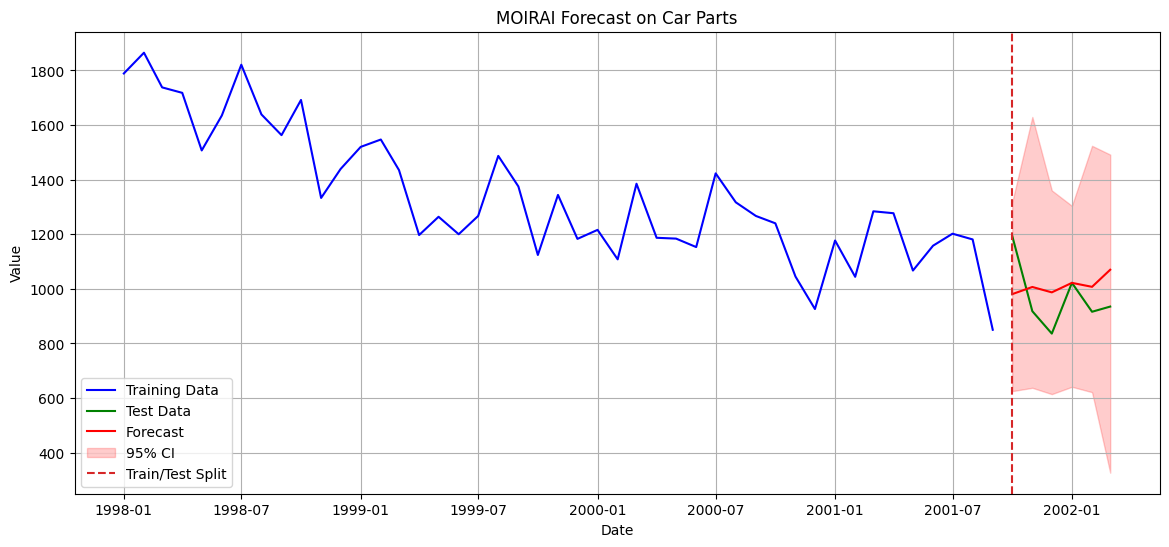

In [ ]:
train_df, test_df = split_train_test(car_parts_df, test_size=0.1)
moirai_forecasts = moirai_forecast(
    train_df=train_df,
    test_df=test_df,
    dataset_name="Car Parts",
    show_plots=True,
)

Could not create Period with freq MS: Invalid frequency: <MonthBegin>
Using fallback Period: 2006-01 with frequency: <MonthEnd>
Could not create Period with freq MS: Invalid frequency: <MonthBegin>
Using fallback Period: 2006-01 with frequency: <MonthEnd>
Could not create Period with freq MS: Invalid frequency: <MonthBegin>
Using fallback Period: 2006-01 with frequency: <MonthEnd>
Could not create Period with freq MS: Invalid frequency: <MonthBegin>
Using fallback Period: 2006-01 with frequency: <MonthEnd>
Could not create Period with freq MS: Invalid frequency: <MonthBegin>
Using fallback Period: 2006-01 with frequency: <MonthEnd>


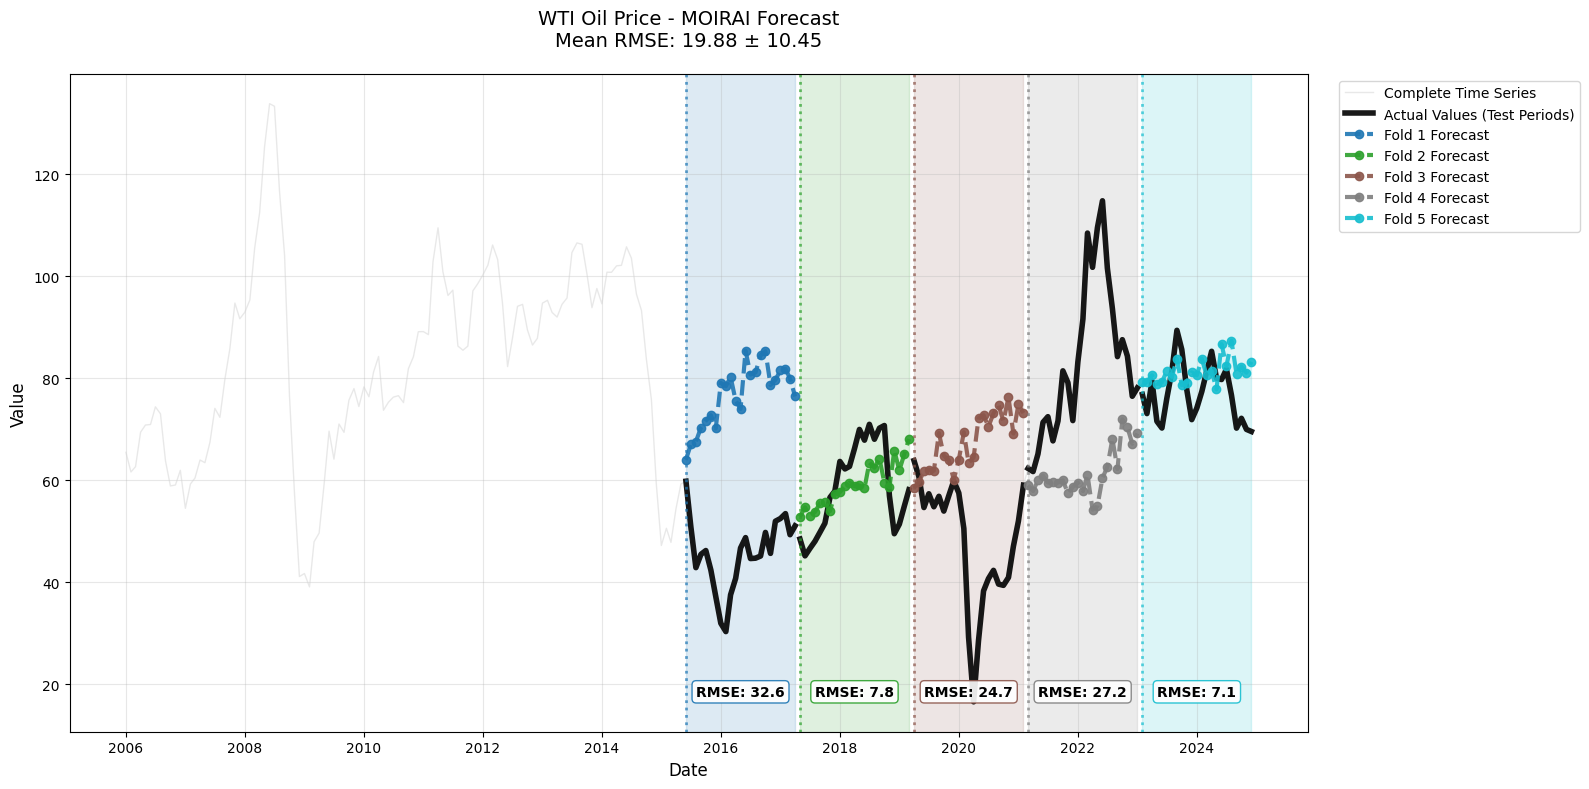

Could not create Period with freq MS: Invalid frequency: <MonthBegin>
Using fallback Period: 1998-01 with frequency: <MonthEnd>
Could not create Period with freq MS: Invalid frequency: <MonthBegin>
Using fallback Period: 1998-01 with frequency: <MonthEnd>
Could not create Period with freq MS: Invalid frequency: <MonthBegin>
Using fallback Period: 1998-01 with frequency: <MonthEnd>
Could not create Period with freq MS: Invalid frequency: <MonthBegin>
Using fallback Period: 1998-01 with frequency: <MonthEnd>
Could not create Period with freq MS: Invalid frequency: <MonthBegin>
Using fallback Period: 1998-01 with frequency: <MonthEnd>


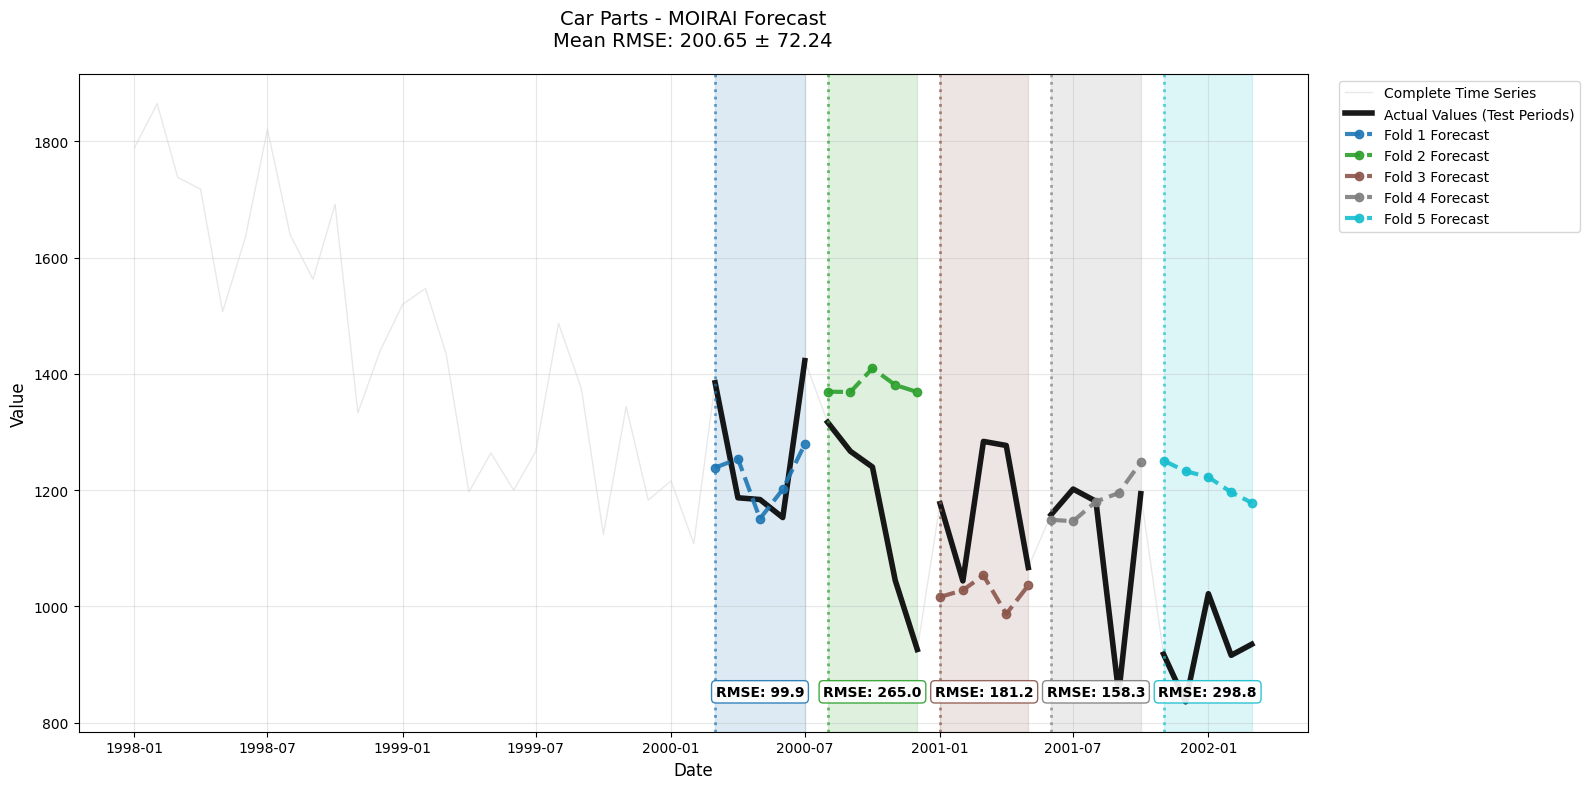

Created Period object: 1993-01-01 with frequency: <Day>
Created Period object: 1993-01-01 with frequency: <Day>
Created Period object: 1993-01-01 with frequency: <Day>
Created Period object: 1993-01-01 with frequency: <Day>
Created Period object: 1993-01-01 with frequency: <Day>


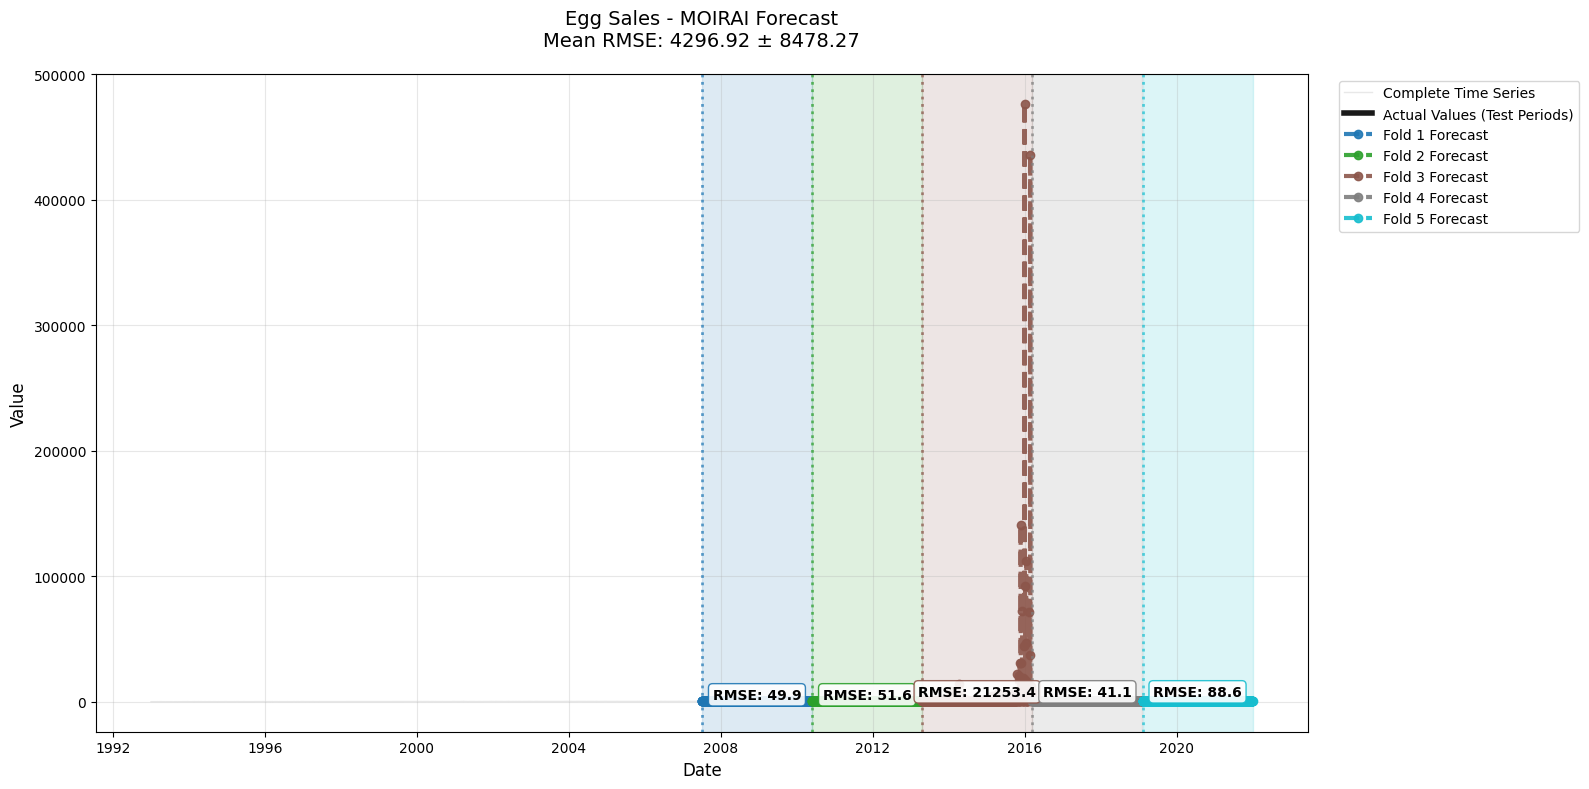

Created Period object: 1915-01-01 with frequency: <Day>
Created Period object: 1915-01-01 with frequency: <Day>
Created Period object: 1915-01-01 with frequency: <Day>
Created Period object: 1915-01-01 with frequency: <Day>
Created Period object: 1915-01-01 with frequency: <Day>


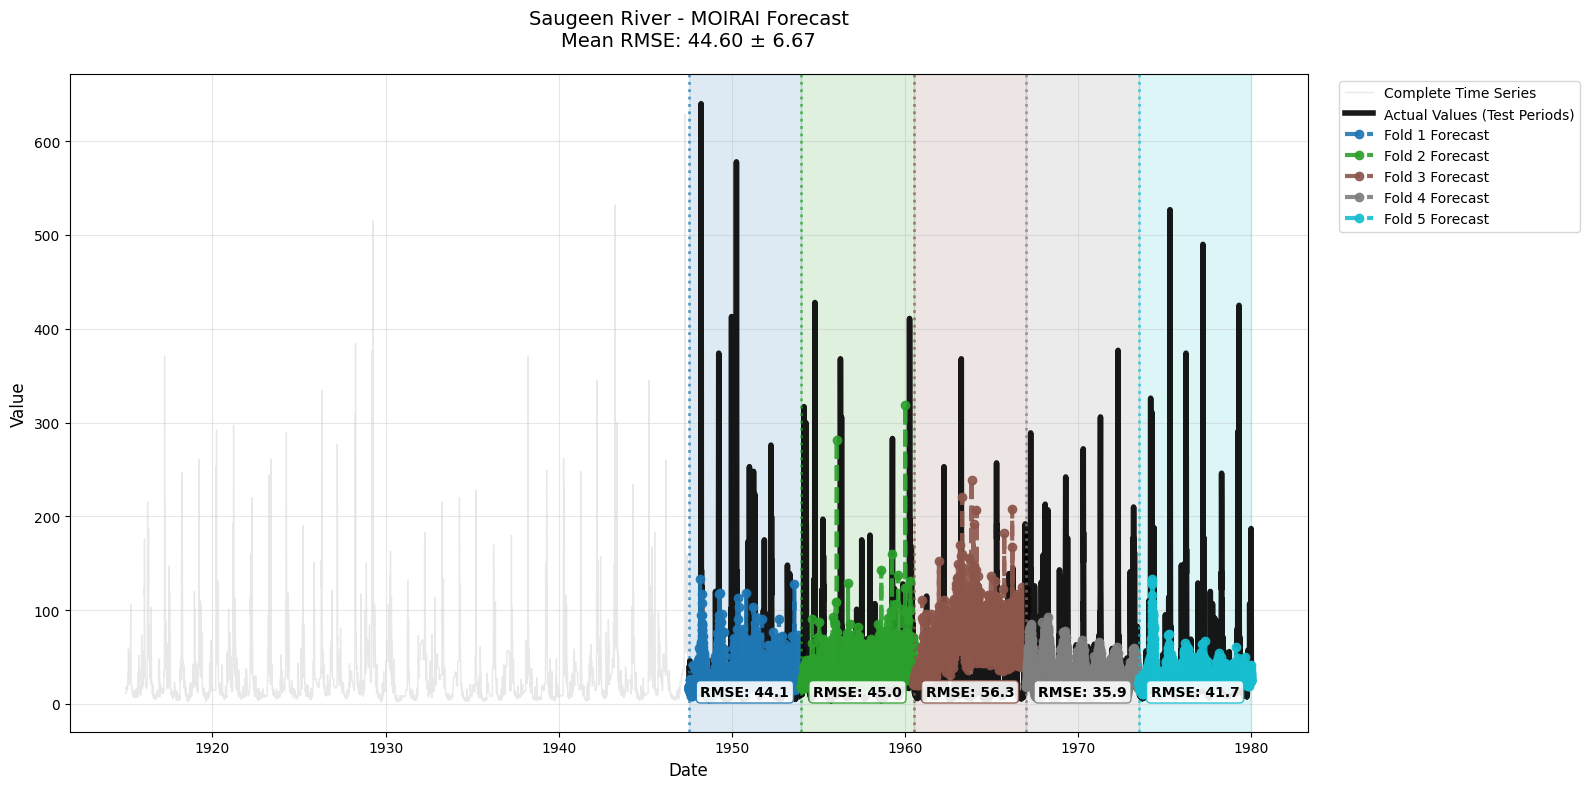

Created Period object: 2002-01-01 with frequency: <Day>
Created Period object: 2002-01-01 with frequency: <Day>
Created Period object: 2002-01-01 with frequency: <Day>
Created Period object: 2002-01-01 with frequency: <Day>
Created Period object: 2002-01-01 with frequency: <Day>


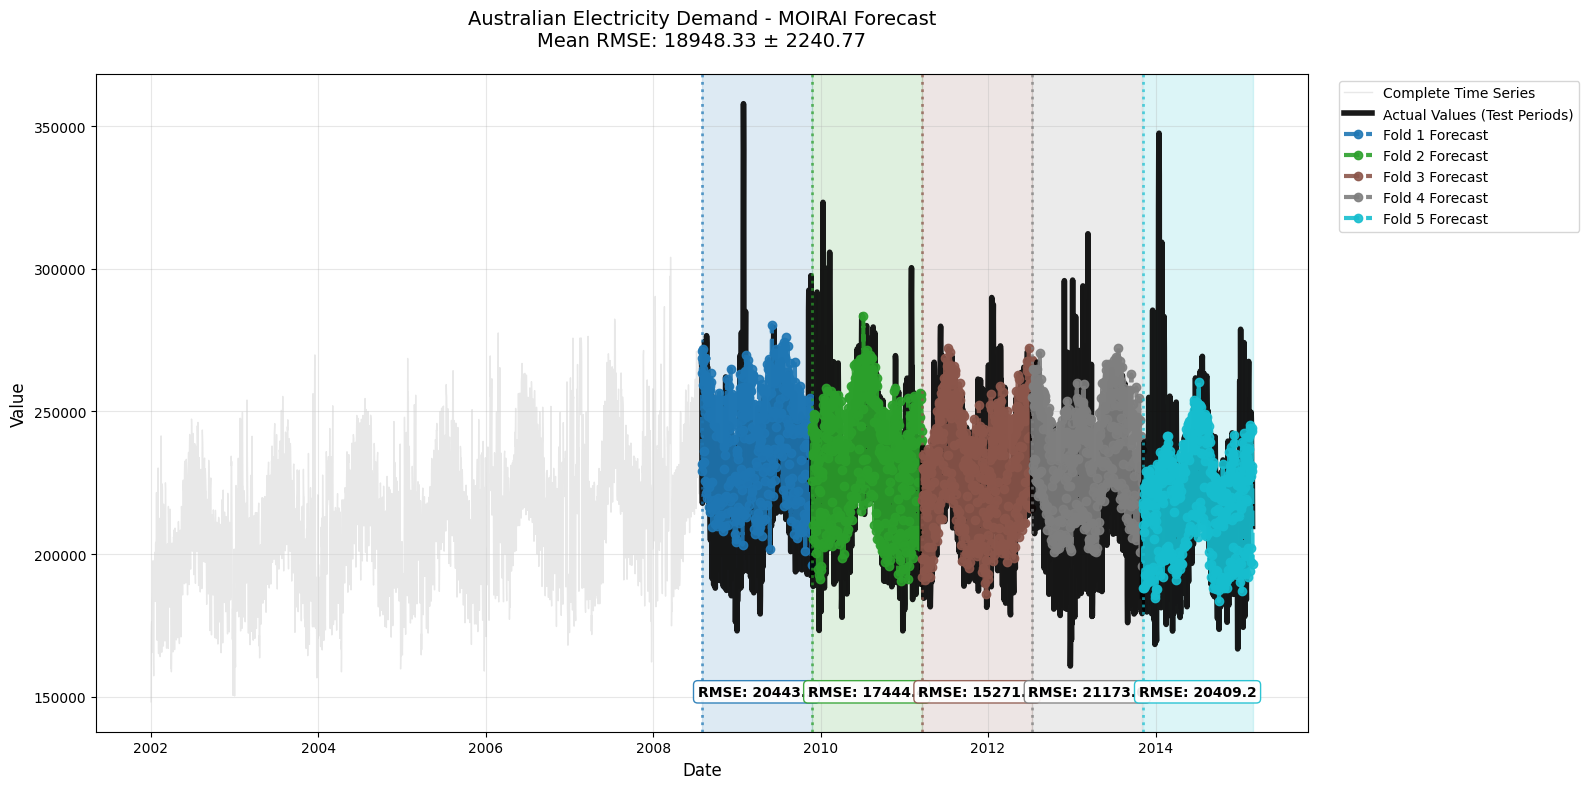

In [ ]:
plot_comprehensive_cv_results(wti_oil_df, moirai_forecast, n_splits=5, dataset_name='wti_oil',
                              title="WTI Oil Price - MOIRAI Forecast")

plot_comprehensive_cv_results(car_parts_df, moirai_forecast, n_splits=5, dataset_name='car_parts',
                              title="Car Parts - MOIRAI Forecast")

plot_comprehensive_cv_results(egg_sales_df, moirai_forecast, n_splits=5, dataset_name='egg_sales',
                              title="Egg Sales - MOIRAI Forecast")
plot_comprehensive_cv_results(saugeen_river_df, moirai_forecast, n_splits=5, dataset_name='saugeen_river',
                              title="Saugeen River - MOIRAI Forecast")
plot_comprehensive_cv_results(australian_electricity_demand_df, moirai_forecast, n_splits=5, dataset_name='australian_electricity_demand',
                              title="Australian Electricity Demand - MOIRAI Forecast")